# `Memgraph`  

*  high-performance in-memory graph database  
*  faster access and efficient in-memory data processing

1. Setup DB  
- may want to setup a metakg database (vs per request setup *--initial testing*)
  
2. Execute request  
    a. basic `get_paths()` req  
    b. &expand `get_paths` req  

In [1]:
import mgclient

#### Setup memgraph connection

In [2]:
conn = mgclient.connect(host="localhost", port=7687)
conn.autocommit = True
cursor = conn.cursor()
cursor.execute("CALL mg.load_all();") # Load MAGE



1. Check for Available MAGE Procedures -- only upload specific package


In [3]:
# Execute the query to list all procedures
cursor.execute("CALL mg.procedures() YIELD *")

# Fetch and display the results
procedures = cursor.fetchall()
for proc in procedures:
    print(proc)


(False, False, 'example_c.procedure', '/usr/lib/memgraph/query_modules/example_c.so', 'example_c.procedure(required_arg :: ANY?, optional_arg = Null :: ANY?) :: (args :: LIST OF ANY?, result :: STRING)')
(False, True, 'example_c.write_procedure', '/usr/lib/memgraph/query_modules/example_c.so', 'example_c.write_procedure(required_arg :: STRING) :: (created_vertex :: NODE)')
(False, True, 'example_cpp.add_x_nodes', '/usr/lib/memgraph/query_modules/example_cpp.so', 'example_cpp.add_x_nodes(param_1 :: INTEGER) :: ()')
(False, False, 'example_cpp.return_true', '/usr/lib/memgraph/query_modules/example_cpp.so', 'example_cpp.return_true(param_1 :: INTEGER, param_2 = 2.3 :: FLOAT) :: (out :: BOOLEAN)')
(False, False, 'graph_analyzer.analyze', '/usr/lib/memgraph/query_modules/graph_analyzer.py', 'graph_analyzer.analyze(analyses = Null :: LIST? OF STRING) :: (name :: STRING, value :: STRING)')
(False, False, 'graph_analyzer.analyze_subgraph', '/usr/lib/memgraph/query_modules/graph_analyzer.py', '

In [ ]:
try:
    cursor.execute("CALL algo.all_simple_paths() YIELD result")
    result = cursor.fetchone()
    print("MAGE function executed successfully. Result:", result)
except Exception as e:
    print("Error executing MAGE function:", e)


View connection and db

In [178]:
conn

In [49]:
# Query to count the total number of nodes
cursor.execute("MATCH (n) RETURN count(n)")
total_count = cursor.fetchone()[0]
print(f"Total number of nodes in the database: {total_count}")
# Query to count the total number of relationships
cursor.execute("MATCH ()-[r]->() RETURN count(r)")
total_relationships = cursor.fetchone()[0]
print(f"Total number of relationships in the database: {total_relationships}")

# Query to fetch and print each node
cursor.execute("MATCH (n) RETURN n")
nodes = cursor.fetchall()
for node in nodes:
    print(node)

Total number of nodes in the database: 224
Total number of relationships in the database: 167827
(<mgclient.Node(id=964, labels={'Subject'}, properties={'name': 'SmallMolecule'}) at 0x111776f40>,)
(<mgclient.Node(id=965, labels={'Object'}, properties={'name': 'PopulationOfIndividualOrganisms'}) at 0x111661920>,)
(<mgclient.Node(id=966, labels={'Object'}, properties={'name': 'PhysiologicalProcess'}) at 0x111663a80>,)
(<mgclient.Node(id=967, labels={'Object'}, properties={'name': 'Procedure'}) at 0x111825aa0>,)
(<mgclient.Node(id=968, labels={'Object'}, properties={'name': 'ChemicalEntity'}) at 0x1118245d0>,)
(<mgclient.Node(id=969, labels={'Object'}, properties={'name': 'ClinicalAttribute'}) at 0x1118244b0>,)
(<mgclient.Node(id=970, labels={'Object'}, properties={'name': 'Annotation'}) at 0x111824de0>,)
(<mgclient.Node(id=971, labels={'Object'}, properties={'name': 'Publication'}) at 0x111825440>,)
(<mgclient.Node(id=972, labels={'Object'}, properties={'name': 'ComplexMolecularMixture'}

Delete all nodes and relationships

In [53]:
# Delete all nodes and relationships
cursor.execute("MATCH (n) DETACH DELETE n")

InterfaceError: bad session

In [ ]:
# Close the connection
conn.close()

##### Build memgraph database -- with `MetaKG` Index

In [5]:
# Import packages
from controller.metakg import MetaKG
from model import ConsolidatedMetaKGDoc


Build the `memgraph` db from the `Metakg` index.  
Should be run once -- similar to `admin.consolidate_metakg()`

In [6]:
index = ConsolidatedMetaKGDoc.Index.name


```
query = """
MERGE (s:Subject {name: $subject})
MERGE (o:Object {name: $object})
MERGE (s)-[r:RELATION {predicate: $predicate}]->(o)
SET r.api = $api
"""
```


1. **MERGE for Subject Node**:
   - `MERGE (s:Subject {name: $subject})`
   - This part of the query ensures that a node with the label `Subject` and a property `name` with the value `$subject` exists in the graph. If such a node doesn't exist, it's created.
   - The `$subject` is a parameter that should be replaced with the actual subject name when the query is executed.

2. **MERGE for Object Node**:
   - `MERGE (o:Object {name: $object})`
   - Similar to the previous step, this ensures that a node with the label `Object` and a property `name` with the value `$object` exists. If not, it's created.
   - The `$object` is another parameter representing the name of the object node.

3. **MERGE for Relationship**:
   - `MERGE (s)-[r:RELATION {predicate: $predicate}]->(o)`
   - This part of the query ensures that a relationship of type `RELATION` with a property `predicate` exists between the subject `s` and the object `o`. If such a relationship doesn’t exist, it's created.
   - The `$predicate` parameter represents the predicate of the relationship.

4. **SET for Relationship's API Property**:
   - `SET r.api = $api`
   - This updates the `api` property of the `RELATION` relationship.
   - The `$api` parameter should be replaced with the actual API information when the query is executed.

In [13]:
def build_memgraph_metakg_db(cursor):
    """Build a Memgraph database from the consolidated MetaKG data."""
    
    # Iterate over consolidated edges
    for edge in MetaKG.get_all_via_scan(size=10000, index=index):
        # Prepare the Cypher query with named parameters
        query = """
        MERGE (s:Subject {name: $subject})
        MERGE (o:Object {name: $object})
        MERGE (s)-[r:RELATION {predicate: $predicate}]->(o)
        SET r.api = $api
        """

        # Prepare parameters as a dictionary
        params = {
            'subject': edge['_source']["subject"],
            'object': edge['_source']["object"],
            'predicate': edge['_source']["predicate"],
            'api': edge['_source']["api"]
        }

        # Execute the query with parameters
        cursor.execute(query, params)

    # Connection should be closed outside this function


In [14]:
build_memgraph_metakg_db(cursor)

---

#### Build memgraph database -- test example setup (by query)

In [15]:
# query filter to find BTE data only
query_data = {
    'q': 'api.name:BTE'
}

In [25]:
def add_to_memgraph(conn, subject, object, predicate, api):
        # Prepare the Cypher query
        query = """
        MERGE (s:Subject {name: $subject})
        MERGE (o:Object {name: $object})
        MERGE (s)-[r:RELATION {predicate: $predicate, api: $api}]->(o)
        """
        params = {'subject': subject, 'object': object, 'predicate': predicate, 'api': api}

        # Execute the query
        cursor = conn.cursor()
        cursor.execute(query, params)
        cursor.close()

In [26]:
# Scroll through search results with direct call to index
i = 0
for doc in MetaKG.get_all_via_scan(size=100, query_data=query_data, index=index):
    i += 1
    # Extract subject, object, and predicate from hit
    subject = doc["_source"]["subject"]
    object = doc["_source"]["object"]
    predicate = doc["_source"]["predicate"]
    api = doc["_source"]["api"]
    # Add to Memgraph
    add_to_memgraph(conn, subject, object, predicate, api)

print(i)

1827


functionalize process above.... 

In [27]:

def populate_memgraph_from_metakg(query_data, index, conn):
    # Scroll through search results with direct call to index
    i = 0
    for doc in MetaKG.get_all_via_scan(size=100, query_data=query_data, index=index):
        i += 1
        # Extract subject, object, and predicate from hit
        subject = doc["_source"]["subject"]
        object = doc["_source"]["object"]
        predicate = doc["_source"]["predicate"]
        api = doc["_source"]["api"]
        # Add to Memgraph
        add_to_memgraph(conn, subject, object, predicate, api)

    print("[INFO] %s documents added to db."%i)

Viewing newly populated memgraph data -

In [111]:
def fetch_and_count_data_from_memgraph(conn, limit=10):
    # Query to fetch a sample of data
    fetch_query = """
    MATCH (s:Subject)-[r:RELATION]->(o:Object) 
    RETURN s.name, r.predicate, o.name, r.api 
    LIMIT $limit
    """
    fetch_params = {'limit': limit}

    # Query to count total relationships
    count_query = "MATCH ()-[r:RELATION]->() RETURN count(r)"

    # Execute fetch query
    cursor = conn.cursor()
    cursor.execute(fetch_query, fetch_params)
    results = cursor.fetchall()

    # Print fetched data
    for result in results:
        print(f"Subject: {result[0]}, Predicate: {result[1]}, Object: {result[2]}, API: {result[3]}")

    # Execute count query
    cursor.execute(count_query)
    total_count = cursor.fetchone()[0]
    cursor.close()

    # Print total count
    print(f"Total number of relationships in Memgraph: {total_count}")

# Use the function
fetch_and_count_data_from_memgraph(conn)


Subject: SmallMolecule, Predicate: correlated_with, Object: PopulationOfIndividualOrganisms, API: [{'bte': {'query_operation': {'input_separator': ',', 'method': 'post', 'params': None, 'path': '/query', 'path_params': None, 'request_body': None, 'server': 'https://automat.transltr.io/icees-kg/1.3', 'support_batch': True}}, 'name': 'Automat-icees-kg(Trapi v1.3.0)', 'smartapi': {'id': '44e7a1147ca8657f50af6bb25982762d', 'metadata': 'https://trapi-openapi.apps.renci.org/trapi/infores:automat-icees-kg/1.3.0', 'ui': 'https://smart-api.info/ui/44e7a1147ca8657f50af6bb25982762d'}, 'tags': ['translator', 'automat', 'trapi', 'bte-trapi'], 'x-translator': {'component': 'KP', 'team': ['Exposures Provider']}}, {'bte': {'query_operation': {'input_separator': ',', 'method': 'post', 'params': None, 'path': '/query', 'path_params': None, 'request_body': None, 'server': 'https://bte.transltr.io/v1', 'support_batch': True}}, 'name': 'BioThings Explorer (BTE) TRAPI', 'smartapi': {'id': 'dc91716f44207d2e1

View graph count

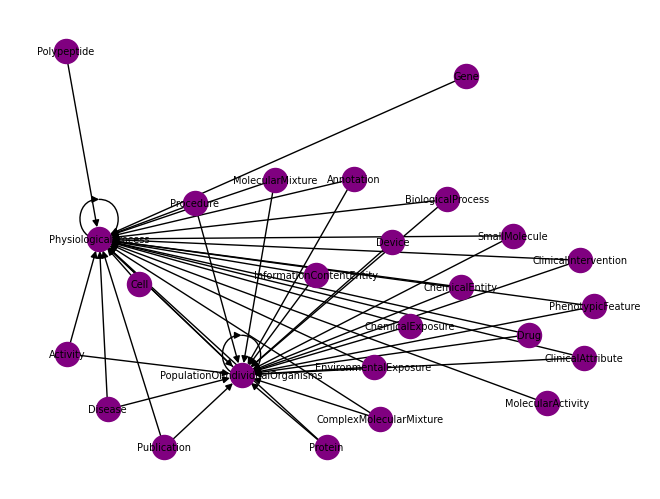

In [35]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(conn, limit=60):
    query = """
    MATCH (s:Subject)-[r:RELATION]->(o:Object) 
    RETURN s.name, o.name 
    LIMIT $limit
    """
    params = {'limit': limit}

    G = nx.DiGraph()
    cursor = conn.cursor()
    cursor.execute(query, params)

    for subject, object in cursor.fetchall():
        G.add_edge(subject, object)

    cursor.close()
    nx.draw(G, with_labels=True, node_color='purple', font_size=7)
    plt.show()

# Use the function
visualize_graph(conn)


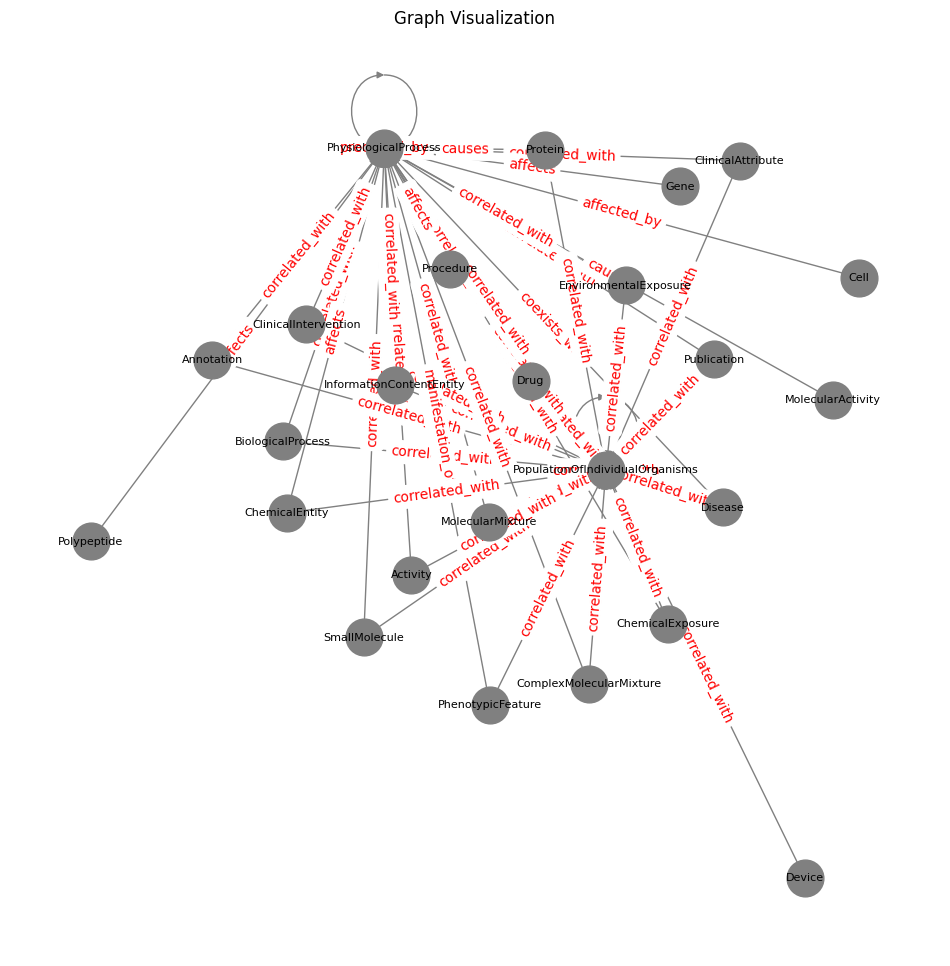

In [38]:


def visualize_graph(conn, limit=60):
    query = """
    MATCH (s:Subject)-[r:RELATION]->(o:Object) 
    RETURN s.name, o.name, r.predicate
    LIMIT $limit
    """
    params = {'limit': limit}

    G = nx.DiGraph()
    cursor = conn.cursor()
    cursor.execute(query, params)

    for subject, object, relation in cursor.fetchall():
        G.add_edge(subject, object, label=relation)

    cursor.close()

    pos = nx.spring_layout(G)  # Using spring layout
    plt.figure(figsize=(12, 12), dpi=100)

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_color='gray', node_size=700)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'), font_color='red')

    plt.title("Graph Visualization")
    plt.axis('off')
    plt.show()

# Use the function
visualize_graph(conn)


In [41]:
def count_and_list_unique_subject_object_relations(conn):
    # Query to count unique subject-to-object relations
    count_query = """
    MATCH (s:Subject)-[r:RELATION]->(o:Object)
    WITH DISTINCT s, o
    RETURN count(*)
    """
    # Query to list unique subject-to-object relations
    list_query = """
    MATCH (s:Subject)-[r:RELATION]->(o:Object)
    RETURN DISTINCT s.name, o.name
    """

    # Execute count query
    cursor = conn.cursor()
    cursor.execute(count_query)
    count = cursor.fetchone()[0]

    # Print the count
    print(f"Total number of unique subject-to-object relations: {count}")

    # Execute list query
    cursor.execute(list_query)
    relations = cursor.fetchall()
    cursor.close()

    # Print the relations
    print("List of unique subject-to-object relations:")
    for subject, object in relations:
        print(f"Subject: {subject}, Object: {object}")

# Use the function
count_and_list_unique_subject_object_relations(conn)


Total number of unique subject-to-object relations: 665
List of unique subject-to-object relations:
Subject: SmallMolecule, Object: PopulationOfIndividualOrganisms
Subject: Drug, Object: PopulationOfIndividualOrganisms
Subject: ChemicalExposure, Object: PopulationOfIndividualOrganisms
Subject: Disease, Object: PopulationOfIndividualOrganisms
Subject: MolecularMixture, Object: PopulationOfIndividualOrganisms
Subject: Publication, Object: PopulationOfIndividualOrganisms
Subject: Protein, Object: PopulationOfIndividualOrganisms
Subject: Procedure, Object: PopulationOfIndividualOrganisms
Subject: EnvironmentalExposure, Object: PopulationOfIndividualOrganisms
Subject: Activity, Object: PopulationOfIndividualOrganisms
Subject: InformationContentEntity, Object: PopulationOfIndividualOrganisms
Subject: BiologicalProcess, Object: PopulationOfIndividualOrganisms
Subject: PhysiologicalProcess, Object: PopulationOfIndividualOrganisms
Subject: ClinicalIntervention, Object: PopulationOfIndividualOrg

---

#### MetaKG Index Testing - 

In [192]:
fetch_and_count_data_from_memgraph(conn)


Subject: SmallMolecule, Predicate: correlated_with, Object: PopulationOfIndividualOrganisms, API: [{'bte': {'query_operation': {'input_separator': ',', 'method': 'post', 'params': None, 'path': '/query', 'path_params': None, 'request_body': None, 'server': 'https://automat.transltr.io/icees-kg/1.3', 'support_batch': True}}, 'name': 'Automat-icees-kg(Trapi v1.3.0)', 'smartapi': {'id': '44e7a1147ca8657f50af6bb25982762d', 'metadata': 'https://trapi-openapi.apps.renci.org/trapi/infores:automat-icees-kg/1.3.0', 'ui': 'https://smart-api.info/ui/44e7a1147ca8657f50af6bb25982762d'}, 'tags': ['translator', 'automat', 'trapi', 'bte-trapi'], 'x-translator': {'component': 'KP', 'team': ['Exposures Provider']}}, {'bte': {'query_operation': {'input_separator': ',', 'method': 'post', 'params': None, 'path': '/query', 'path_params': None, 'request_body': None, 'server': 'https://bte.transltr.io/v1', 'support_batch': True}}, 'name': 'BioThings Explorer (BTE) TRAPI', 'smartapi': {'id': 'dc91716f44207d2e1

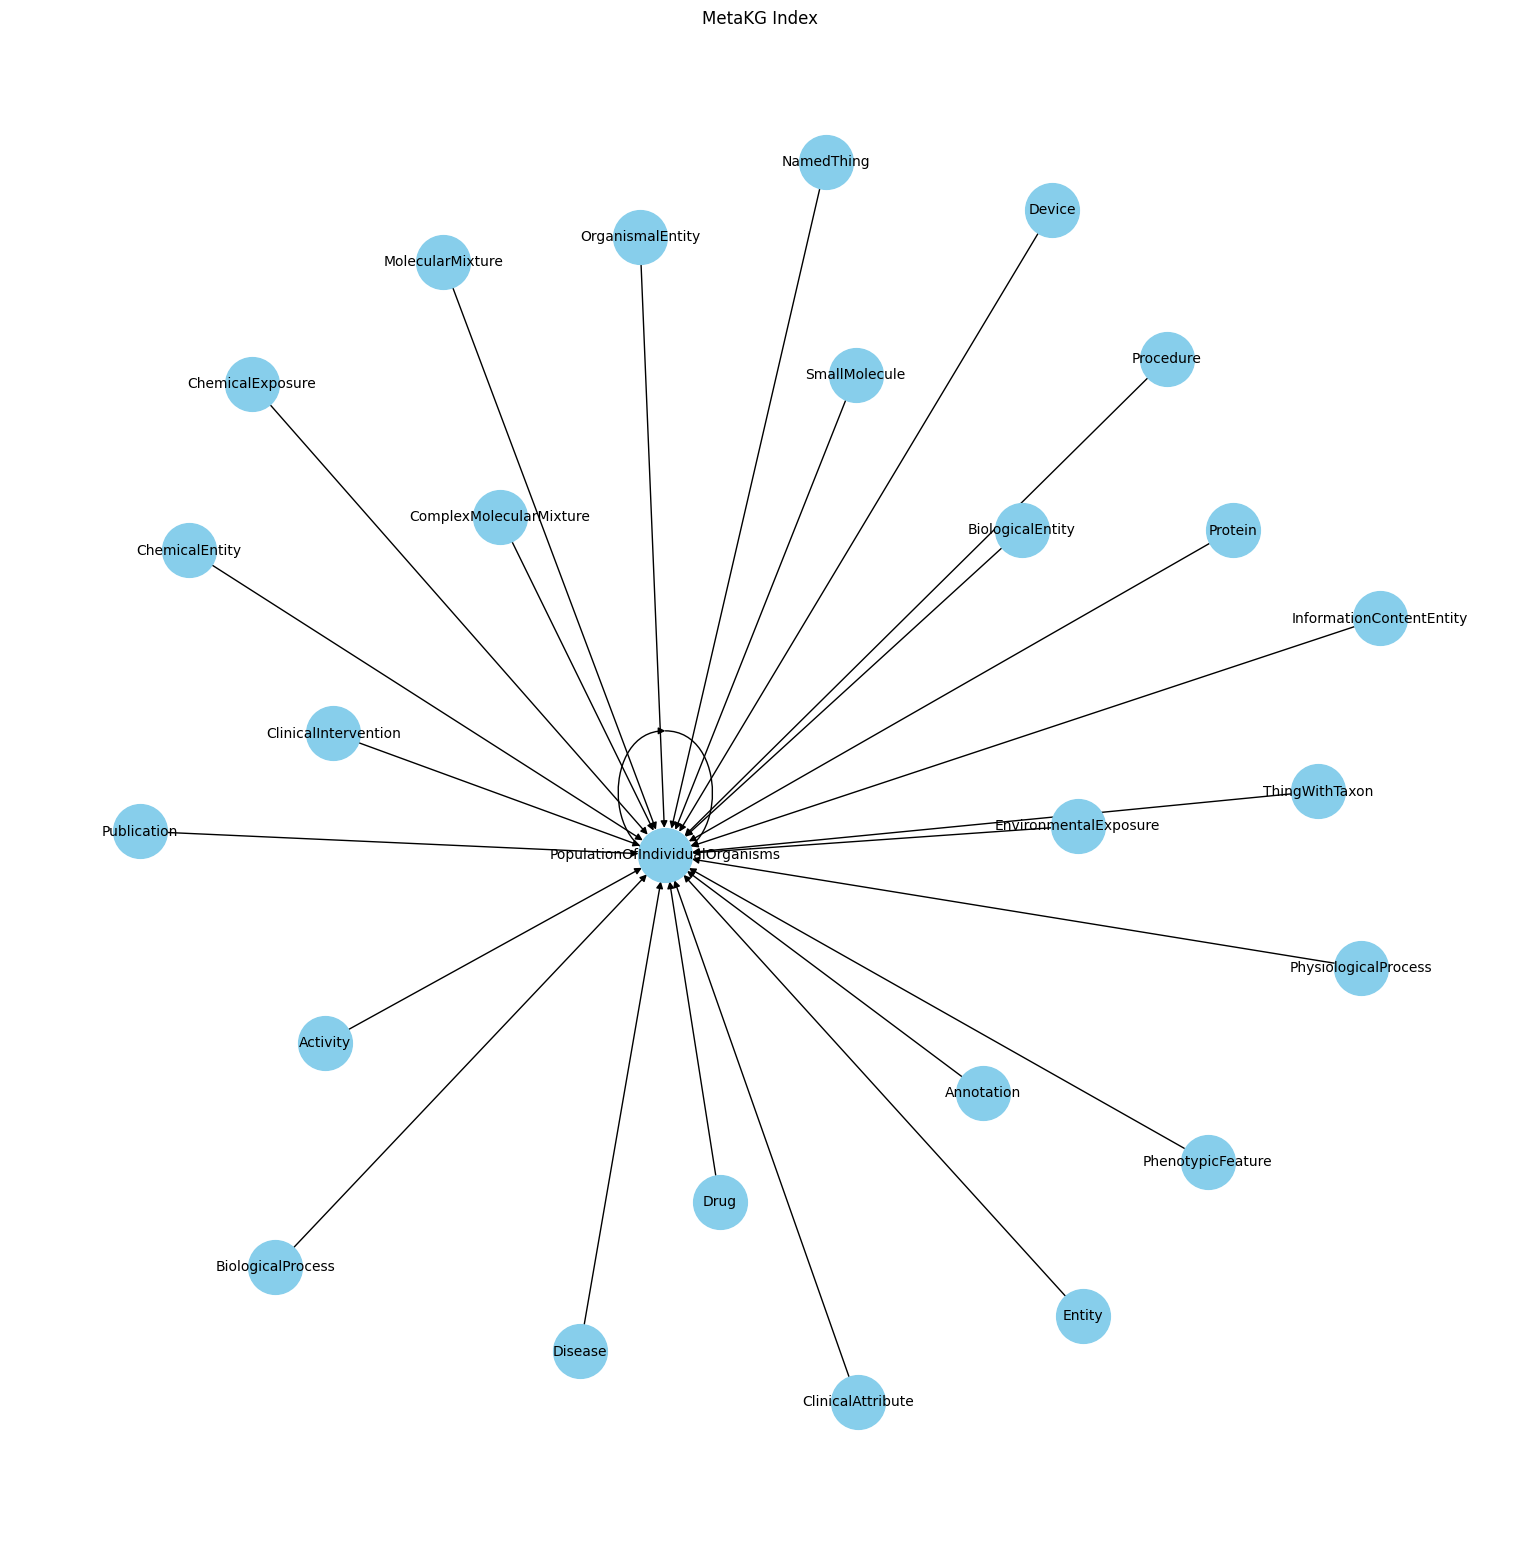

In [201]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(conn, limit=30):
    query = """
    MATCH (s:Subject)-[r:RELATION]->(o:Object) 
    RETURN s.name, o.name 
    LIMIT $limit
    """
    params = {'limit': limit}

    G = nx.DiGraph()
    cursor = conn.cursor()
    cursor.execute(query, params)

    for subject, object in cursor.fetchall():
        G.add_edge(subject, object)

    cursor.close()

    # Use a spring layout for better visualization of nodes
    pos = nx.spring_layout(G)
    plt.figure(figsize=(15, 15))  # Increase figure size
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=10)
    plt.title("MetaKG Index")
    plt.show()

# Use the function
visualize_graph(conn)


In [155]:
# paths=get_paths(cursor, 'PhenotypicFeature', 'PhysiologicalProcess')

### Update predicate retrieval

In [18]:
def get_predicates_between_nodes(subject_name, object_name):
        """
        Retrieve all predicates between a subject and object from Memgraph.

        Parameters:
        - subject_name: str
            The name of the subject node.
        - object_name: str
            The name of the object node.

        Returns:
        - predicates: list of dict
            A list of dictionaries, each representing a predicate and its associated data.
        """
        query = """
        MATCH (s:Subject {name: $subject_name})-[r:RELATION]->(o:Object {name: $object_name})
        RETURN r.predicate, r.api
        """
        params = {'subject_name': subject_name, 'object_name': object_name}

        cursor = conn.cursor()
        cursor.execute(query, params)
        results = cursor.fetchall()
        cursor.close()

        predicates = []
        for predicate, api in results:
            predicates.append({"predicate": predicate, "api": api})
        return predicates

In [23]:
predicates=get_predicates_between_nodes(subject, object)
len(predicates)

65

### Get Paths

In [51]:
subject='PhenotypicFeature'
object= 'PhysiologicalProcess'

In [44]:
# Verify that nodes of type PhenotypicFeature exist
cursor.execute("MATCH (n:Subject {name: 'PhenotypicFeature'}) RETURN n.name LIMIT 1")
result = cursor.fetchone()
print("PhenotypicFeature as Subject exists:", result)


# Verify that nodes of type PhysiologicalProcess exist
cursor.execute("MATCH (n:Object {name: 'PhysiologicalProcess'}) RETURN n.name LIMIT 1")
result = cursor.fetchone()
print("PhysiologicalProcess as Object exists:", result)



PhenotypicFeature as Subject exists: ('PhenotypicFeature',)
PhysiologicalProcess as Object exists: ('PhysiologicalProcess',)


In [52]:
subject_name = subject  # Replace with actual subject node name
object_name = object  # Replace with actual object node name

query = """
MATCH (subject:Subject {name: $subject_name}), (object:Subject {name: $object_name})
CALL algo.all_simple_paths(subject, object, [], 3) YIELD path
RETURN path
"""
params = {'subject_name': subject_name, 'object_name': object_name}

cursor.execute(query, params)



mg_raw_transport_recv: connection closed by server


DatabaseError: failed to receive chunk size

In [33]:
# Assuming you have already executed a query with cursor.execute()
result = cursor.fetchone()
while result is not None:
    print(result)
    result = cursor.fetchone()


*Add more verifcation method grabs all relations*

In [ ]:
def get_graph(cursor):
        """
        Construct a directed graph from data in a Memgraph database.

        Returns:
        - G: nx.DiGraph
            A directed graph constructed from the Memgraph data.
        """
        G = nx.DiGraph()
        # Cypher query to fetch all relevant nodes and relationships
        query = """
        MATCH (s)-[r]->(o)
        RETURN s.name AS subject, o.name AS object, r.predicate AS predicate, r.api AS api
        """

        cursor.execute(query)
        results = cursor.fetchall()

        for subject, object, predicate, api in results:
            # Add the subject & object to the graph
            G.add_edge(subject, object, predicate=predicate, api=api)

        return G

In [ ]:
def get_paths(subject, object, cutoff=3, api_details=False):
    # all_predicates = self.get_all_predicates()  # Get all predicates once
    # -- taking out because not needed anymore 

    def process_api_content(edge_data): 
        if api_details:
            return edge_data['api']
        else:
            return [{"name": item.get("name"), "smartapi": {"id": item["smartapi"]["id"]}}
                    for item in edge_data['api']]

    paths_with_edges = []
    if nx.has_path(G, subject, object):
        for path in nx.all_simple_paths(self.G, source=subject, target=object, cutoff=cutoff):
            edges = []
            for source_node, target_node in zip(path, path[1:]):
                edge_data = all_predicates.get((source_node, target_node), [])
                for data in edge_data:
                    edges.append({
                        "subject": source_node,
                        "object": target_node,
                        "predicate": data["predicate"],
                        "api": process_api_content(data)
                    })

            paths_with_edges.append({"path": path, "edges": edges})

    return paths_with_edges

---

In [1]:
from utils.metakg import path_finder

In [2]:
# query filter to find BTE data only
query_data = {
    'q': 'api.name:BTE'
}

In [3]:
# Usage example
path_finder = path_finder.MetaKGPathFinder(query_data=query_data)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


Memgraph database created.
NetworkX graph created.


In [11]:
path_finder.G.nodes

NodeView(('SmallMolecule', 'PopulationOfIndividualOrganisms', 'Drug', 'ChemicalExposure', 'Disease', 'MolecularMixture', 'Publication', 'Protein', 'Procedure', 'EnvironmentalExposure', 'Activity', 'InformationContentEntity', 'BiologicalProcess', 'PhysiologicalProcess', 'ClinicalIntervention', 'ComplexMolecularMixture', 'ClinicalAttribute', 'Annotation', 'Device', 'OrganismalEntity', 'BiologicalEntity', 'Entity', 'ThingWithTaxon', 'NamedThing', 'PhenotypicFeature', 'ChemicalEntity', 'GrossAnatomicalStructure', 'Phenomenon', 'PathologicalProcess', 'DiseaseOrPhenotypicFeature', 'MolecularActivity', 'RNAProduct', 'Agent', 'AnatomicalEntity', 'Vitamin', 'Cohort', 'PhysicalEntity', 'MolecularEntity', 'Food', 'Gene', 'GeographicLocation', 'Polypeptide', 'OrganismTaxon', 'BehavioralFeature', 'LifeStage', 'CellularComponent', 'Pathway', 'IndividualOrganism', 'Transcript', 'NucleicAcidEntity', 'GeneFamily', 'BiologicalProcessOrActivity', 'Behavior', 'Event', 'CellLine', 'MaterialSample', 'Protei

In [4]:
subject='Behavior'
object='BiologicalEntity'

In [5]:
pathlist = path_finder.get_paths(subject=subject, object=object, cutoff=3)

DatabaseError: Memory limit exceeded! Attempting to allocate a chunk of 112.00MiB which would put the current use to 14.71GiB, while the maximum allowed size for allocation is set to 14.65GiB.

In [ ]:
pathlist = path_finder.get_paths(subject=subject, object=object, cutoff=3)

getting paths
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates...
getting predicates
returning predicates.

KeyboardInterrupt: 

In [ ]:
pathlist[0]

{'path': ['ChemicalEntity',
  'PopulationOfIndividualOrganisms',
  'PhysiologicalProcess',
  'PlanetaryEntity'],
 'edges': [{'subject': 'ChemicalEntity',
   'object': 'PopulationOfIndividualOrganisms',
   'predicate': 'correlated_with',
   'api': [{'name': 'Automat-icees-kg(Trapi v1.3.0)',
     'smartapi': {'id': '44e7a1147ca8657f50af6bb25982762d'}},
    {'name': 'BioThings Explorer (BTE) TRAPI',
     'smartapi': {'id': 'dc91716f44207d2e1287c727f281d339'}}]},
  {'subject': 'ChemicalEntity',
   'object': 'PopulationOfIndividualOrganisms',
   'predicate': 'regulates',
   'api': [{'name': 'RTX KG2 - TRAPI 1.3.0',
     'smartapi': {'id': 'ccd4a8bb83de81401e9a27f1d8e7f948'}},
    {'name': 'RTX KG2',
     'smartapi': {'id': 'd6ea093bcb5476331d309623cbece11a'}},
    {'name': 'ARAX Translator Reasoner - TRAPI 1.3.0',
     'smartapi': {'id': 'e248aefca0f469229e82cca80fbabc89'}}]},
  {'subject': 'ChemicalEntity',
   'object': 'PopulationOfIndividualOrganisms',
   'predicate': 'located_in',
   'a

In [ ]:
memgraph_nodes = path_finder.get_memgraph_nodes(limit=5)  # Get 5 nodes


In [ ]:
# Printing properties of fetched nodes
for node in memgraph_nodes:
    for key, value in node.properties.items():
        print(f"  {key}: {value}")


  name: SmallMolecule
  name: PopulationOfIndividualOrganisms
  name: PhysiologicalProcess
  name: Procedure
  name: ChemicalEntity


In [ ]:
path_finder.view_predicates_in_graph(limit=5)


Subject: SmallMolecule, Predicate: correlated_with, Object: PopulationOfIndividualOrganisms, API: [{'bte': {'query_operation': {'input_separator': ',', 'method': 'post', 'params': None, 'path': '/query', 'path_params': None, 'request_body': None, 'server': 'https://automat.transltr.io/icees-kg/1.3', 'support_batch': True}}, 'name': 'Automat-icees-kg(Trapi v1.3.0)', 'smartapi': {'id': '44e7a1147ca8657f50af6bb25982762d', 'metadata': 'https://trapi-openapi.apps.renci.org/trapi/infores:automat-icees-kg/1.3.0', 'ui': 'https://smart-api.info/ui/44e7a1147ca8657f50af6bb25982762d'}, 'tags': ['translator', 'automat', 'trapi', 'bte-trapi'], 'x-translator': {'component': 'KP', 'team': ['Exposures Provider']}}, {'bte': {'query_operation': {'input_separator': ',', 'method': 'post', 'params': None, 'path': '/query', 'path_params': None, 'request_body': None, 'server': 'https://bte.transltr.io/v1', 'support_batch': True}}, 'name': 'BioThings Explorer (BTE) TRAPI', 'smartapi': {'id': 'dc91716f44207d2e1

In [ ]:
path_finder.G

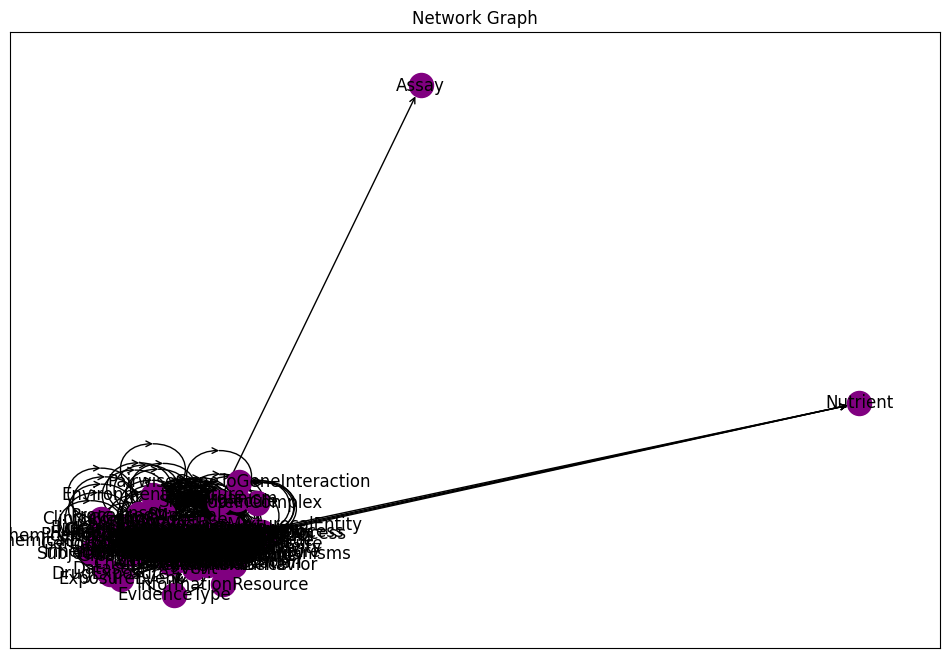

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming path_finder.G is your DiGraph
G = path_finder.G

# Draw the graph
plt.figure(figsize=(12, 8))  # Set the size of the plot
pos = nx.spring_layout(G)  # This is a layout for the nodes
nx.draw_networkx_nodes(G, pos, node_color='purple')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10)
nx.draw_networkx_labels(G, pos)

plt.title("Network Graph")
plt.show()


In [ ]:
for path in paths:
    print(path)

In [ ]:
len(pathlist)

4504

In [ ]:
import pprint

In [ ]:
pathlist[0].keys()
pathlist[0]['path']


['ChemicalEntity',
 'PopulationOfIndividualOrganisms',
 'PhysiologicalProcess',
 'PlanetaryEntity']

In [ ]:
pprint.pprint(pathlist[0])

{'edges': [{'api': [{'name': 'Automat-icees-kg(Trapi v1.3.0)',
                     'smartapi': {'id': '44e7a1147ca8657f50af6bb25982762d'}},
                    {'name': 'BioThings Explorer (BTE) TRAPI',
                     'smartapi': {'id': 'dc91716f44207d2e1287c727f281d339'}}],
            'object': 'PopulationOfIndividualOrganisms',
            'predicate': 'correlated_with',
            'subject': 'ChemicalEntity'},
           {'api': [{'name': 'RTX KG2 - TRAPI 1.3.0',
                     'smartapi': {'id': 'ccd4a8bb83de81401e9a27f1d8e7f948'}},
                    {'name': 'RTX KG2',
                     'smartapi': {'id': 'd6ea093bcb5476331d309623cbece11a'}},
                    {'name': 'ARAX Translator Reasoner - TRAPI 1.3.0',
                     'smartapi': {'id': 'e248aefca0f469229e82cca80fbabc89'}}],
            'object': 'PopulationOfIndividualOrganisms',
            'predicate': 'regulates',
            'subject': 'ChemicalEntity'},
           {'api': [{'name': 'RTX KG2

---